# 서울 미세먼지 예측(LSTM)

               date area  pm10  pm2.5
0  2022-12-31 23:00  강남구 57.00  44.00
1  2022-12-31 23:00  강동구 68.00  55.00
2  2022-12-31 23:00  강북구 59.00  42.00
3  2022-12-31 23:00  강서구 62.00  40.00
4  2022-12-31 23:00  관악구 57.00  38.00
Epoch 1/20


d:\241223\aiProject2\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5694/5694 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 7.0399e-04 - val_loss: 0.0022
Epoch 3/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 6.9814e-04 - val_loss: 0.0021
Epoch 4/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 6.5189e-04 - val_loss: 0.0021
Epoch 5/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 6.6109e-04 - val_loss: 0.0021
Epoch 6/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 6.4593e-04 - val_loss: 0.0021
Epoch 7/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 6.1709e-04 - val_loss: 0.0021
Epoch 8/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 6.1691e-04 - val_loss: 0.0021
Epoch 9/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 6.2296e-04 - val_loss: 0.0021
Epoch 10/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 6.3644e-04 - val_loss: 0.0021
Epoch 11/20
5694/5694 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 5.8996e-04 - val_los

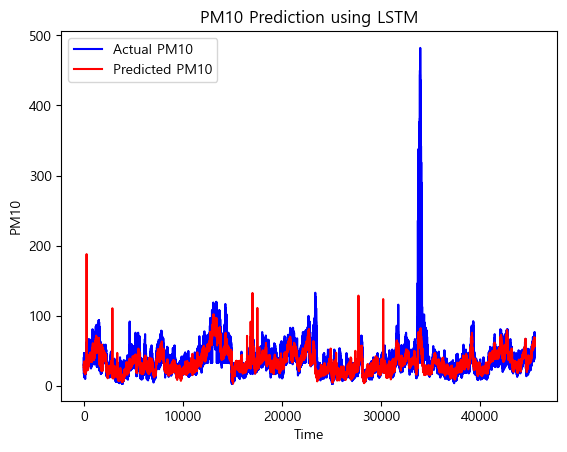

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

#데이터 로드
file_path="dataset/seoul_pm10.csv";
data=pd.read_csv(file_path, encoding="cp949");

#데이터 확인
print(data.head());

#데이터 전처리

# 결측치 처리
data['pm10'] = data['pm10'].fillna(data['pm10'].mean());
data['pm2.5'] = data['pm2.5'].fillna(data['pm2.5'].mean());

# 'pm10' 값은 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data['pm10'] = scaler.fit_transform(data[['pm10']])


#날짜 데이터 처리
data["date"]=pd.to_datetime(data["date"]);  #날짜 데이터가 있다면 datetime 형식으로 변환
data=data.sort_values(by="date");      #날짜 순으로 정렬

#원핫 인코딩
data=pd.get_dummies(data, columns=["area"], drop_first=True);

#데이터 분할
#"pm10" 예측을 위한 데이터셋 구성
X=data.drop(columns=["date","pm10"])    #예측에 사용할 특성
y=data["pm10"]      #예측할 값

#훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, shuffle=False);

# X 데이터가 float형인지 확인 후, 필요시 변환
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

#LSTM을 위한 데이터 변형
def create_dataset(X,y, time_step=1):
    X_data, y_data=[],[];
    for i in range(len(X)-time_step):
        X_data.append(X.iloc[i:(i+time_step)].values);
        y_data.append(y.iloc[i+time_step]);
    return np.array(X_data), np.array(y_data);

#LSTM 모델 학습을위한 데이터셋 생성
time_step=10;
X_train_lstm, y_train_lstm=create_dataset(X_train,y_train,time_step);
X_test_lstm, y_test_lstm=create_dataset(X_test,y_test,time_step);

#데이터 차원 변경
X_train_lstm=X_train_lstm.reshape(X_train_lstm.shape[0],X_train_lstm.shape[1],X_train_lstm.shape[2]);
X_test_lstm=X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1],X_train_lstm.shape[2]);

#LSTM 모델 구축
model=Sequential();
model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_lstm.shape[1],X_train_lstm.shape[2])));
model.add(Dropout(0.2));
model.add(LSTM(units=50, return_sequences=False));
model.add(Dropout(0.2));
model.add(Dense(units=1));  #pm10 예측

#모델 컴파일
model.compile(optimizer="adam", loss="mean_squared_error");

#모델 학습
history=model.fit(X_train_lstm,y_train_lstm, epochs=20, batch_size=32, validation_data=(X_test_lstm,y_test_lstm))

#모델 평가 및 예측
predicted_pm10=model.predict(X_test_lstm);

#결과 시각화
predicted_pm10_rescaled=scaler.inverse_transform(predicted_pm10);
y_test_rescaled=scaler.inverse_transform(y_test_lstm.reshape(-1,1));
plt.plot(y_test_rescaled, color="blue", label="Actual PM10");
plt.plot(predicted_pm10_rescaled, color="red",label="Predicted PM10");
plt.title("PM10 Prediction using LSTM");
plt.xlabel("Time");
plt.ylabel("PM10");
plt.legend();
plt.show();




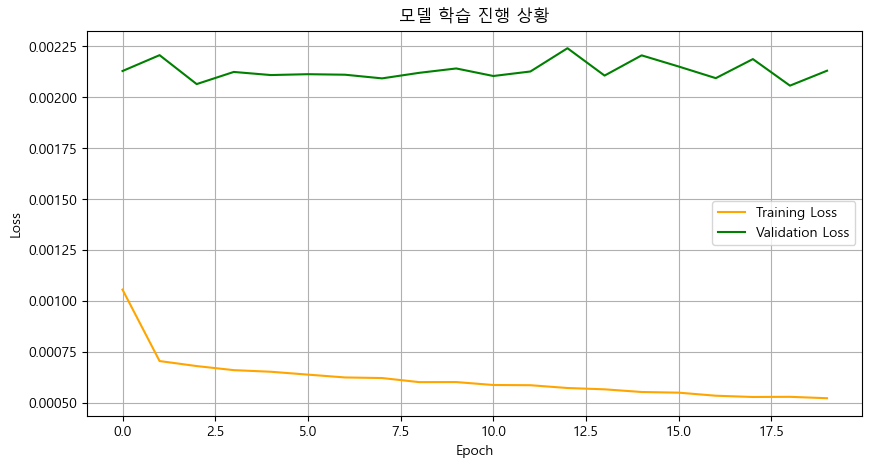

In [3]:
# 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('모델 학습 진행 상황')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()